In [44]:
import numpy as np
import nibabel
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import statistics
from PIL import Image
import skimage
import logging
from tqdm import tqdm
import sklearn
import sklearn.metrics
import seaborn as sns
logging.basicConfig(level=logging.INFO, force=True)

In [3]:
volume = './volume-100.nii.gz'
mask = './segmentation-100.nii.gz'
masks = './masks_tumor_png/'
images = './images_tumor_png/'
prediction = './prediction_masks/'

In [4]:
images = [
    './images_tumor_png/volume-100/412.png',
    './images_tumor_png/volume-100/442.png',
    './images_tumor_png/volume-100/467.png'
]

images = [ np.asarray(Image.open(i)) for i in images ]

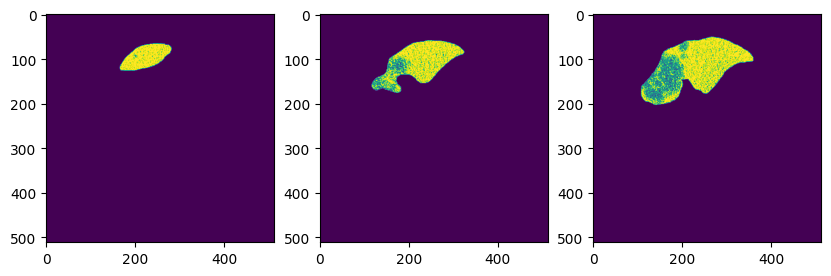

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(images[0])

plt.subplot(132)
plt.imshow(images[1])

plt.subplot(133)
plt.imshow(images[2])

In [6]:
I0, I1, I2 = images

In [7]:
skimage.filters.threshold_multiotsu(I0)

array([ 96, 222])

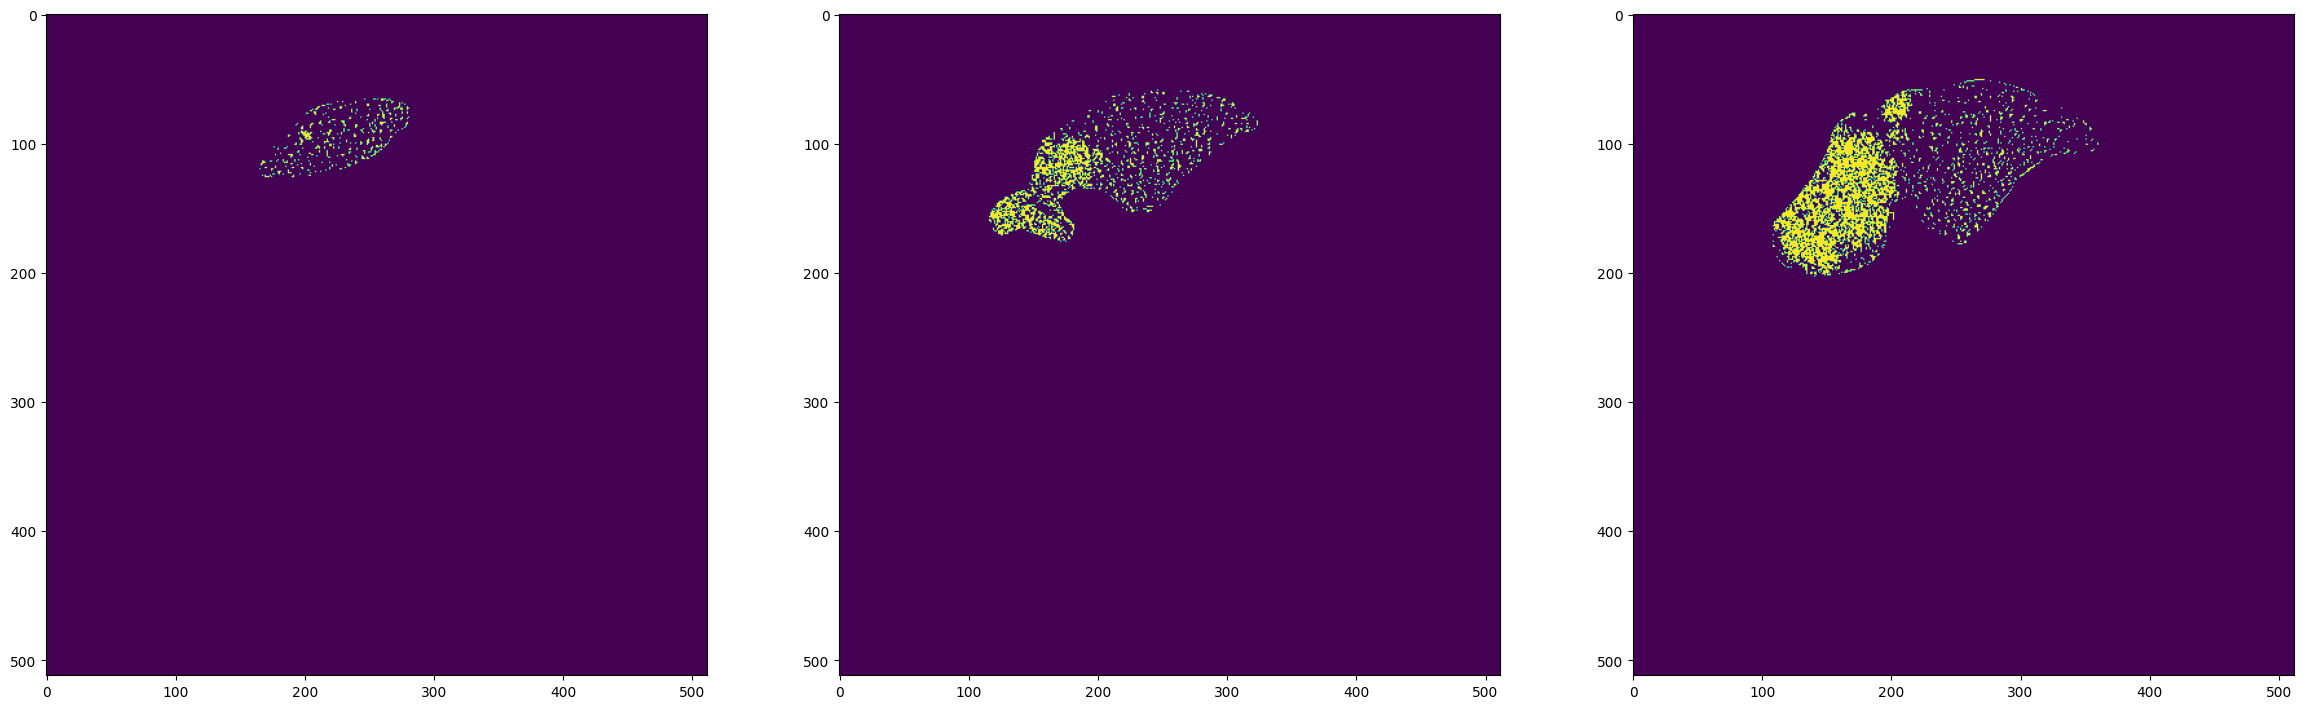

In [8]:
plt.figure(figsize=(29, 10))
a, b = skimage.filters.threshold_multiotsu(I0)
plt.subplot(131)
plt.imshow((I0 > a) & (I0 < b))

a, b = skimage.filters.threshold_multiotsu(I1)
plt.subplot(132)
plt.imshow((I1 > a) & (I1 < b))

a, b = skimage.filters.threshold_multiotsu(I2)
plt.subplot(133)
plt.imshow((I2 > a) & (I2 < b))

In [86]:
def segment_tumor(Ipath, dst_path):
    I = skimage.io.imread(Ipath)
    a, b = skimage.filters.threshold_multiotsu(I)
    T = ((a <= I) & (I <= b))
    print(a, b-a, 255-b)
    T0 = skimage.morphology.area_closing(T, area_threshold=64)
    T2 = skimage.morphology.remove_small_objects(T0, connectivity=8, min_size=64)
    T2 = np.uint8(skimage.exposure.rescale_intensity(T2, in_range='image', out_range=(0, 255)))
    return skimage.io.imsave(dst_path, T2, check_contrast=False)

In [ ]:
all_images = sorted(glob('images_tumor_png/**/*.png'))
for image in tqdm(all_images):
    segment_tumor(image, image.replace('images_tumor_png', 'prediction_masks'))

In [49]:
prediction = sorted(glob('prediction_masks/**/*.png'))

In [66]:
Z = np.zeros((512, 512))
def dice_score(ground, pred):
    G = (cv2.imread(ground, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)
    P = (cv2.imread(pred, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)

    intersection = np.sum(G * P)
    union = np.sum(G) + np.sum(P)
    dice_coefficient = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice_coefficient

def dice_score2(ground, pred):
    G = (cv2.imread(ground, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)
    P = (cv2.imread(pred, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)

    return sklearn.metrics.jaccard_score(G.flatten(), P.flatten())

In [74]:
def get_area(I):
    t, Ith = cv2.threshold(I, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(Ith, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours]
    return sum(areas)

In [83]:
scores = []
areas = []
AREA_MIN = 2000

all_masks = sorted(glob('./masks_tumor_png/**/*.png'))
for ground, pred in zip(tqdm(all_masks), prediction):
    G = (cv2.imread(ground, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)
    P = (cv2.imread(pred, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)

    if get_area(G) >= AREA_MIN:
        scores.append(sklearn.metrics.jaccard_score(G.flatten(), P.flatten()))

100%|████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:08<00:00, 31.19it/s]


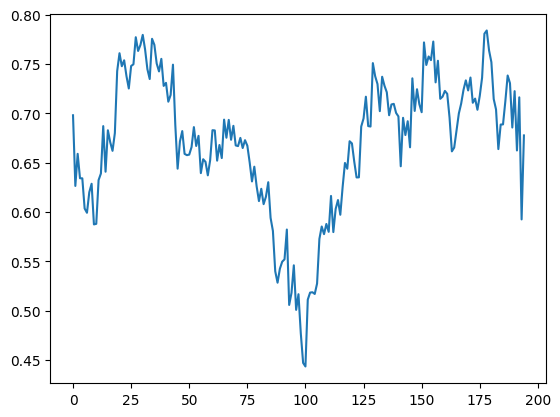

In [84]:
scores = np.array(scores)
plt.plot(scores)

In [85]:
np.mean(scores)

0.6698456657757701